In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import xarray as xr
import os
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy import stats
import geocat.viz.util as gvutil
import cmaps as gvcmaps
from geocat.comp import eofunc_eofs, eofunc_pcs
from sklearn.cross_decomposition import CCA
import geocat.viz as gv
import cdo
import matplotlib.colors as colors
import matplotlib.patches as mpatch
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

In [2]:
#CDO.2.0.5 version is used to remove annual cycle (anomalies), to calculate annual means and to select the Atlantic Basin
from cdo import *

cdo = Cdo()

***Data***

Source of the SST data: https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html 
Source of the SIC data: https://nsidc.org/data/g02202/versions/5 . 

***Anomalies***

Towards performing the analyses presented in this script the following treatment is applied to all data sets: first, the annual cycle is removed from the original time series. Second, monthly anomalies are calculated relative to the 1980 – 2010 period. Thereafter, means are computed.

***EOF on NSIDC SIC data***

In [3]:
fnc = 'anm.anom_SIC_NSIDC_monthly_means_1980_2022.nc'
ds1_sic = xr.open_dataset(fnc)
print(ds1_sic)

<xarray.Dataset> Size: 357MB
Dimensions:    (time: 43, bnds: 2, lon: 1440, lat: 720)
Coordinates:
  * time       (time) datetime64[ns] 344B 1980-06-30T18:00:00 ... 2022-06-30T...
  * lon        (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * lat        (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 688B ...
    iceconc    (time, lat, lon) float64 357MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 10 13:03:59 2025: cdo -O -s -selyear,1980/2022 /isi...
    frequency:    mon
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...


In [4]:


# ----- Period and area setting ------
ystr = 1980
yend = 2022

latS = -90.
latN = 90.
lonW = 0.
lonE = 360.

neof = 8

anm = ds1_sic.iceconc

# -- EOF --
anmnD = anm.sortby("lat", ascending=True)  # Changed 'latitude' to 'lat'
clat = anmnD['lat'].astype(np.float64)  # Changed 'latitude' to 'lat'
clat = np.sqrt(np.cos(np.deg2rad(clat)))
wanm = anmnD 
wanm = anmnD * clat
wanm.attrs = anmnD.attrs
#wanm.attrs['long_name'] = 'Wgt: ' + wanm.attrs['long_name']
#print(wanm)

lon = wanm['lon']  # Changed 'longitude' to 'lon'
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm = wanm.assign_coords(lon=((lon + 180) % 360 - 180))
   wanm = wanm.sortby("lon")
   print(' change longitude ')
#print(wanm)

xw = wanm.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))  # Changed 'latitude' to 'lat' and 'longitude' to 'lon'
xw_anm = xw.transpose('time', 'lat', 'lon')  # Changed 'latitude' to 'lat' and 'longitude' to 'lon'
#print(xw_anm)

eofs_sic = eofunc_eofs(xw_anm.data, neofs=neof, meta=True)
pcs_sic = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)
pcs_norm_sic = pcs_sic / pcs_sic.std(dim='time')
pcs_sic['time'] = anmnD['time']
pcs_norm_sic['time'] = anmnD['time']
pcs_sic.attrs['varianceFraction'] = eofs_sic.attrs['varianceFraction']
pcs_norm_sic.attrs['varianceFraction'] = eofs_sic.attrs['varianceFraction']
#print(pcs_norm_sic)
sdev_pc1 = pcs_sic[0].std(dim='time')
#print(sdev_pc1)
evec_sic = xr.DataArray(
    data=eofs_sic,
    dims=('eof', 'lat', 'lon'),  # Changed 'latitude' to 'lat' and 'longitude' to 'lon'
    coords={'eof': np.arange(0, neof), 'lat': xw['lat'], 'lon': xw['lon']}  # Changed 'latitude' to 'lat' and 'longitude' to 'lon'
)
#print(evec_sic)


***Reconstruct the SIC field based on the first 8 EOFs***

In [5]:
# Parameters
n_modes = 8  # Number of EOFs to use in the reconstruction

reconstructed_field = sum(
    pcs_sic.isel(pc=i).values[:, np.newaxis, np.newaxis] * evec_sic.isel(eof=i).values
    for i in range(n_modes)
)
print("Reconstructed Field Shape:", reconstructed_field.shape)

# Convert to xarray.DataArray
reconstructed_field_da = xr.DataArray(
    data=reconstructed_field,
    dims=('time', 'lat', 'lon'),
    coords={
        'time': pcs_sic['time'],  # Use time dimension from PCs
        'lat': evec_sic['lat'],   # Use latitude dimension from EOFs
        'lon': evec_sic['lon']    # Use longitude dimension from EOFs
    },
    name="sic"
)

# Add attributes
reconstructed_field_da.attrs['long_name'] = "Reconstructed SIC"
reconstructed_field_da.attrs['units'] = "percentage (%)"

# Save to NetCDF
output_file = "SIC_reconstructed_first8EOFs.nc"
reconstructed_field_da.to_netcdf(output_file)

print(f"Reconstructed field saved to {output_file}")

Reconstructed Field Shape: (43, 720, 1440)
Reconstructed field saved to SIC_reconstructed_first8EOFs.nc


In [6]:
#export the PCs in a format usable for CCA
df3=pcs_norm_sic.to_dataframe().unstack().transpose() 
df3.to_csv('RezEOF.sic.NSIDC.1980.2022.8PCs.normalized.VF.txt')
#df3

***EOF on SST data***

In [7]:
fnc = 'anm.anom.sst.Ersstv5.19802022.nc'
dsg = xr.open_dataset(fnc)
print(dsg)

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 43, bnds: 2, lon: 180, lat: 89)
Coordinates:
  * time       (time) datetime64[ns] 344B 1980-06-16 1981-06-16 ... 2022-06-16
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 688B ...
    sst        (time, lat, lon) float32 3MB ...
Attributes: (12/39)
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    source:                    In situ data: ICOADS R3.0 before 2015, NCEP in...
    institution:               This version written at NOAA/ESRL PSD: obtaine...
    Conventions:               CF-1.6, ACDD-1.3
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    ...                        ...
    license:

In [8]:
#Select period and region

ystr = 1980
yend = 2022

latS = -88.
latN = 88.
lonW = 0.
lonE = 358.

neof = 8

anm=dsg.sst
#print(anm)

anmD = anm.sortby("lat", ascending=True)
clat = anmD['lat'].astype(np.float64)
clat = np.sqrt(np.cos(np.deg2rad(clat)))
wanm = anmD 
wanm = anmD* clat
wanm.attrs = anmD.attrs
#wanm.attrs['long_name'] = 'Wgt: ' + wanm.attrs['long_name']
#print(wanm)

lon = wanm['lon']
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm=wanm.assign_coords(lon=( (lon + 180) % 360 - 180) )
   wanm = wanm.sortby("lon")
   print(' change longitude ')
         #print(wanm)  
    
xw = wanm.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))
xw_anm = xw.transpose('time', 'lat', 'lon')
    #print(xw_anm)
    
lon = wanm['lon']
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm=wanm.assign_coords(lon=( (lon + 180) % 360 - 180) )
   wanm = wanm.sortby("lon")
   print(' change longitude ')
 
#print(wanm) 

# -- Perfom EOF analysis

eofs_sst = eofunc_eofs(xw_anm.data, neofs=neof, meta=True)
pcs_sst = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)
pcs_norm_sst = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)
sdev_sst=pcs_sst.std(dim='time')
pcs_norm_sst = pcs_sst / pcs_sst.std(dim='time')
pcs_norm_sst['time']=anmD['time']
pcs_sst['time']=anmD['time']
pcs_sst.attrs['varianceFraction'] = eofs_sst.attrs['varianceFraction']
pcs_norm_sst.attrs['varianceFraction'] = eofs_sst.attrs['varianceFraction']
#print(pcs)
evec_sst = xr.DataArray(data=eofs_sst, dims=('eof','lat','lon'),
    coords = {'eof': np.arange(0,neof), 'lat': xw['lat'], 'lon': xw['lon']} )
#print(evec_sst)

***Reconstruct the SST field based on the first 8 EOFs***

In [9]:
import netCDF4

# Step 1: Multiply each EOF with its associated PC to reconstruct the initial field
eof_pcs_products = []
for i in range(8):  
    eof_pcs_product = pcs_sst[i, :] * evec_sst.sel(eof=i)
    eof_pcs_products.append(eof_pcs_product)

# Step 2: Sum the products to reconstruct the initial field
reconstructed_field = sum(eof_pcs_products)

# Output file setup
output_file = "SST_rec8EOF19802020_ok.nc"
ncfile = netCDF4.Dataset(output_file, mode='w', format='NETCDF4')

# Create dimensions
ncfile.createDimension('lat', reconstructed_field.sizes['lat'])
ncfile.createDimension('lon', reconstructed_field.sizes['lon'])
ncfile.createDimension('time', reconstructed_field.sizes['time'])

# Create variables in the NetCDF file
latitudes = ncfile.createVariable('lat', np.float32, ('lat',))
longitudes = ncfile.createVariable('lon', np.float32, ('lon',))
times = ncfile.createVariable('time', np.float64, ('time',))  # Use np.float64 for datetime64 compatibility

# Assign data to variables
latitudes[:] = reconstructed_field['lat'].values
longitudes[:] = reconstructed_field['lon'].values

# Convert numpy.datetime64 to datetime objects
datetime_values = pd.to_datetime(dsg['time'].values).to_pydatetime()

# Assign time data with correct units and values
times.units = 'days since 1980-01-01 00:00:00'
times.calendar = 'gregorian'
times[:] = netCDF4.date2num(datetime_values, units=times.units, calendar=times.calendar)

# sst variable
sst_var = ncfile.createVariable('sst', np.float32, ('time', 'lat', 'lon'))
sst_var[:, :, :] = reconstructed_field.data  

# Close the file
ncfile.close()

In [10]:
#export the PCs in a format usable for CCA

df=pcs_norm_sst.to_dataframe().unstack().transpose() 
df.to_csv('RezEOF.PC.sst.obs.19802022.8pcs.normalized.txt')

In [11]:
# open the two datasets, reconstructed based on 8EOFS and their asociated PCs

field1 = 'SST_rec8EOF19802020_ok.nc'
ds1 = xr.open_dataset(field1)
#print(ds1)

field2 = 'SIC_reconstructed_first8EOFs.nc'
ds2= xr.open_dataset(field2)
#print(ds2)

PCsV1=pd.read_csv('RezEOF.PC.sst.obs.19802022.8pcs.normalized.txt',sep=',')
PCsV1_xr=PCsV1.to_xarray().to_array()
PCsSST=PCsV1[['0','1','2','3','4','5','6','7']]

PCsV2=pd.read_csv('RezEOF.sic.NSIDC.1980.2022.8PCs.normalized.VF.txt',sep=',')
PCsV2_xr=PCsV2.to_xarray().to_array()
PCsSIC=PCsV2[['0','1','2','3','4','5','6','7']]
#X2

In [12]:
#Normalize the PCs (if necesary) 
X1_mc = (PCsSST-PCsSST.mean())/(PCsSST.std())
#X1_mc.head()
X2_mc = (PCsSIC-PCsSIC.mean())/(PCsSIC.std())
#X2_mc.head()

In [13]:
#Perform CCA

ca = CCA(n_components=8)
ca.fit(X1_mc, X2_mc)
X_c, Y_c = ca.transform(X1_mc, X2_mc)

#export the pairs of maximum correlated PCs obtained from CCA

cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1],
                       "CCX_3":X_c[:, 2],
                       "CCY_3":Y_c[:, 2],
                       "CCX_4":X_c[:, 3],
                       "CCY_4":Y_c[:, 3],
                        "CCX_5":X_c[:, 4],
                        "CCY_5":Y_c[:, 4],
                        "CCX_6":X_c[:, 5],
                         "CCY_6":Y_c[:, 5],
                         "CCX_7":X_c[:, 6],
                         "CCY_7":Y_c[:, 6],
                         "CCX_8":X_c[:, 7],
                         "CCY_8":Y_c[:, 7],
                       #"Species":df.species.tolist(),
                      })
# cc_res.head()

***Obtain the corelatio coefficients betweent the time series of the CCA pairs***

In [14]:
CCAresultPccorr=[]
for p in range (np.shape(X_c)[1]):
        print(np.corrcoef(X_c[:, p], Y_c[:, p]))

[[1.         0.95459024]
 [0.95459024 1.        ]]
[[1.         0.86300854]
 [0.86300854 1.        ]]
[[1.        0.7696294]
 [0.7696294 1.       ]]
[[1.         0.63398181]
 [0.63398181 1.        ]]
[[1.         0.57069825]
 [0.57069825 1.        ]]
[[1.         0.43956552]
 [0.43956552 1.        ]]
[[1.         0.06032085]
 [0.06032085 1.        ]]
[[1.         0.01199961]
 [0.01199961 1.        ]]


In [15]:
#select the 8 individual time series from each pair 
rezcca=cc_res.to_xarray()
PC1sst=rezcca['CCX_1']
PC1sic=rezcca['CCY_1']
PC2sst=rezcca['CCX_2']
PC2sic=rezcca['CCY_2']
PC3sst=rezcca['CCX_3']
PC3sic=rezcca['CCY_3']
PC4sst=rezcca['CCX_4']
PC4sic=rezcca['CCY_4']
PC5sst=rezcca['CCX_5']
PC5sic=rezcca['CCY_5']
PC6sst=rezcca['CCX_6']
PC6sic=rezcca['CCY_6']
PC7sst=rezcca['CCX_7']
PC7sic=rezcca['CCY_7']
PC8sst=rezcca['CCX_8']
PC8sic=rezcca['CCY_8']

#reindex the time axis in the PCs
PC1sst= PC1sst.rename({"index": "time"})
PC2sst= PC2sst.rename({"index": "time"})
PC3sst= PC3sst.rename({"index": "time"})
PC4sst= PC4sst.rename({"index": "time"})
PC5sst= PC5sst.rename({"index": "time"})
PC6sst= PC6sst.rename({"index": "time"})
PC7sst= PC7sst.rename({"index": "time"})
PC8sst= PC8sst.rename({"index": "time"})

PC1sic= PC1sic.rename({"index": "time"})
PC2sic= PC2sic.rename({"index": "time"})
PC3sic= PC3sic.rename({"index": "time"})
PC4sic= PC4sic.rename({"index": "time"})
PC5sic= PC5sic.rename({"index": "time"})
PC6sic= PC6sic.rename({"index": "time"})
PC7sic= PC7sic.rename({"index": "time"})
PC8sic= PC8sic.rename({"index": "time"})

PC1sst['time'] = ds1.time
PC2sst['time'] = ds1.time
PC3sst['time'] = ds1.time
PC4sst['time'] = ds1.time
PC5sst['time'] = ds1.time
PC6sst['time'] = ds1.time
PC7sst['time'] = ds1.time
PC8sst['time'] = ds1.time


PC1sic['time'] = ds2.time
PC2sic['time'] = ds2.time
PC3sic['time'] = ds2.time
PC4sic['time'] = ds2.time
PC5sic['time'] = ds2.time
PC6sic['time'] = ds2.time
PC7sic['time'] = ds2.time
PC8sic['time'] = ds2.time


***Obtain the spatial structures of each CCA pair through linear regression analysis of reconstructed SST/SIC fields on time series from each pair***

In [16]:
regSST1 = xr.cov(PC1sst.load(), ds1.sst.load(), dim="time")/PC1sst.var(dim='time',skipna=True).values
regSST2 = xr.cov(PC2sst.load(), ds1.sst.load(), dim="time")/PC2sst.var(dim='time',skipna=True).values
regSST3 = xr.cov(PC3sst.load(), ds1.sst.load(), dim="time")/PC3sst.var(dim='time',skipna=True).values
regSST4 = xr.cov(PC4sst.load(), ds1.sst.load(), dim="time")/PC4sst.var(dim='time',skipna=True).values
regSST5 = xr.cov(PC5sst.load(), ds1.sst.load(), dim="time")/PC5sst.var(dim='time',skipna=True).values
regSST6 = xr.cov(PC6sst.load(), ds1.sst.load(), dim="time")/PC6sst.var(dim='time',skipna=True).values
regSST7 = xr.cov(PC7sst.load(), ds1.sst.load(), dim="time")/PC7sst.var(dim='time',skipna=True).values
regSST8 = xr.cov(PC8sst.load(), ds1.sst.load(), dim="time")/PC8sst.var(dim='time',skipna=True).values

regSIC1 = xr.cov(PC1sic.load(), ds2.sic.load(), dim="time")/PC1sic.var(dim='time',skipna=True).values
regSIC2 = xr.cov(PC2sic.load(), ds2.sic.load(), dim="time")/PC2sic.var(dim='time',skipna=True).values
regSIC3 = xr.cov(PC3sic.load(), ds2.sic.load(), dim="time")/PC3sic.var(dim='time',skipna=True).values
regSIC4 = xr.cov(PC4sic.load(), ds2.sic.load(), dim="time")/PC4sic.var(dim='time',skipna=True).values
regSIC5 = xr.cov(PC5sic.load(), ds2.sic.load(), dim="time")/PC5sic.var(dim='time',skipna=True).values
regSIC6 = xr.cov(PC6sic.load(), ds2.sic.load(), dim="time")/PC6sic.var(dim='time',skipna=True).values
regSIC7 = xr.cov(PC7sic.load(), ds2.sic.load(), dim="time")/PC7sic.var(dim='time',skipna=True).values
regSIC8 = xr.cov(PC8sic.load(), ds2.sic.load(), dim="time")/PC8sic.var(dim='time',skipna=True).values

***Obtain the variance explained by each spatial structures (as average of r squared), through corelation analysis between the CCA time series from each pair and the SST/SIC fields, reconstructed based on the first 8 EOFs***

In [17]:
# Obtain the percentage of variance explained by each SST structure

cor_SST1 = xr.corr(PC1sst.load(), ds1.sst.load(), dim="time")
r1_squared = cor_SST1*cor_SST1
var_sst1=(r1_squared.mean()*100)
var_sst1_round=var_sst1.round(decimals=1)
print(var_sst1_round)

cor_SST2 = xr.corr(PC2sst.load(), ds1.sst.load(), dim="time")
r2_squared = cor_SST2*cor_SST2
var_sst2=r2_squared.mean()*100
var_sst2_round=var_sst2.round(decimals=1)
print(var_sst2_round)

cor_SST3 = xr.corr(PC3sst.load(), ds1.sst.load(), dim="time")
r3_squared = cor_SST3*cor_SST3
var_sst3=r3_squared.mean()*100
var_sst3_round=var_sst3.round(decimals=1)
print(var_sst3_round)

cor_SST4 = xr.corr(PC4sst.load(), ds1.sst.load(), dim="time")
r4_squared = cor_SST4*cor_SST4
var_sst4=r4_squared.mean()*100
var_sst4_round=var_sst4.round(decimals=1)
print(var_sst4_round)

cor_SST5 = xr.corr(PC5sst.load(), ds1.sst.load(), dim="time")
r5_squared = cor_SST5*cor_SST5
var_sst5=r5_squared.mean()*100
var_sst5_round=var_sst5.round(decimals=1)
print(var_sst5_round)

cor_SST6 = xr.corr(PC6sst.load(), ds1.sst.load(), dim="time")
r6_squared = cor_SST6*cor_SST6
var_sst6=r6_squared.mean()*100
var_sst6_round=var_sst6.round(decimals=1)
print(var_sst6_round)

cor_SST7 = xr.corr(PC7sst.load(), ds1.sst.load(), dim="time")
r7_squared = cor_SST7*cor_SST7
var_sst7=r7_squared.mean()*100
var_sst7_round=var_sst7.round(decimals=1)
print(var_sst7_round)

cor_SST8 = xr.corr(PC8sst.load(), ds1.sst.load(), dim="time")
r8_squared = cor_SST8*cor_SST8
var_sst8=r8_squared.mean()*100
var_sst8_round=var_sst8.round(decimals=1)
print(var_sst8_round)

<xarray.DataArray ()> Size: 8B
array(39.)
<xarray.DataArray ()> Size: 8B
array(14.)
<xarray.DataArray ()> Size: 8B
array(12.3)
<xarray.DataArray ()> Size: 8B
array(6.9)
<xarray.DataArray ()> Size: 8B
array(9.4)
<xarray.DataArray ()> Size: 8B
array(6.4)
<xarray.DataArray ()> Size: 8B
array(5.8)
<xarray.DataArray ()> Size: 8B
array(6.2)


In [18]:
# Calculate and print the correlation and variance explained for the Arctic and Antarctic SIC spatial structures of each CCA pair
def calculate_correlation_variance(pc_series, sic_data, hemisphere_prefix):
    cor_sic = xr.corr(pc_series.load(), sic_data.sic.load(), dim="time")
    r_squared_sic = cor_sic ** 2
    var_sic = r_squared_sic.mean() * 100
    var_sic_round = var_sic.round(decimals=2)
    print(f"{hemisphere_prefix}_SIC Variance Explained: {var_sic_round}%")

# Selecting Northern and Southern Hemisphere data
northern_hemisphere_data = ds2.sel(lat=slice(30, 90))
southern_hemisphere_data = ds2.sel(lat=slice(-90, -30))

# Calculate correlations and variances for each PC series for both hemispheres
for i in range(1, 9):
    pc_series = globals()[f'PC{i}sic']  
    calculate_correlation_variance(pc_series, northern_hemisphere_data, f"north_PC{i}")
    calculate_correlation_variance(pc_series, southern_hemisphere_data, f"south_PC{i}")

north_PC1_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(51.98)%
south_PC1_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(15.81)%
north_PC2_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(3.62)%
south_PC2_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(17.32)%
north_PC3_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(8.87)%
south_PC3_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(9.87)%
north_PC4_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(8.17)%
south_PC4_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(12.23)%
north_PC5_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(5.02)%
south_PC5_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(15.02)%
north_PC6_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(11.36)%
south_PC6_SIC Variance Explained: <xarray.DataArray ()> Size: 8B
array(6.42)%
north_PC7_SIC Variance Explained: <xarray.DataArray ()> Si

***PLOT CCA PAIRS***

***Pair 1***

In [19]:
import cartopy.util as cutil
import numpy as np
import matplotlib.colors as mcolors

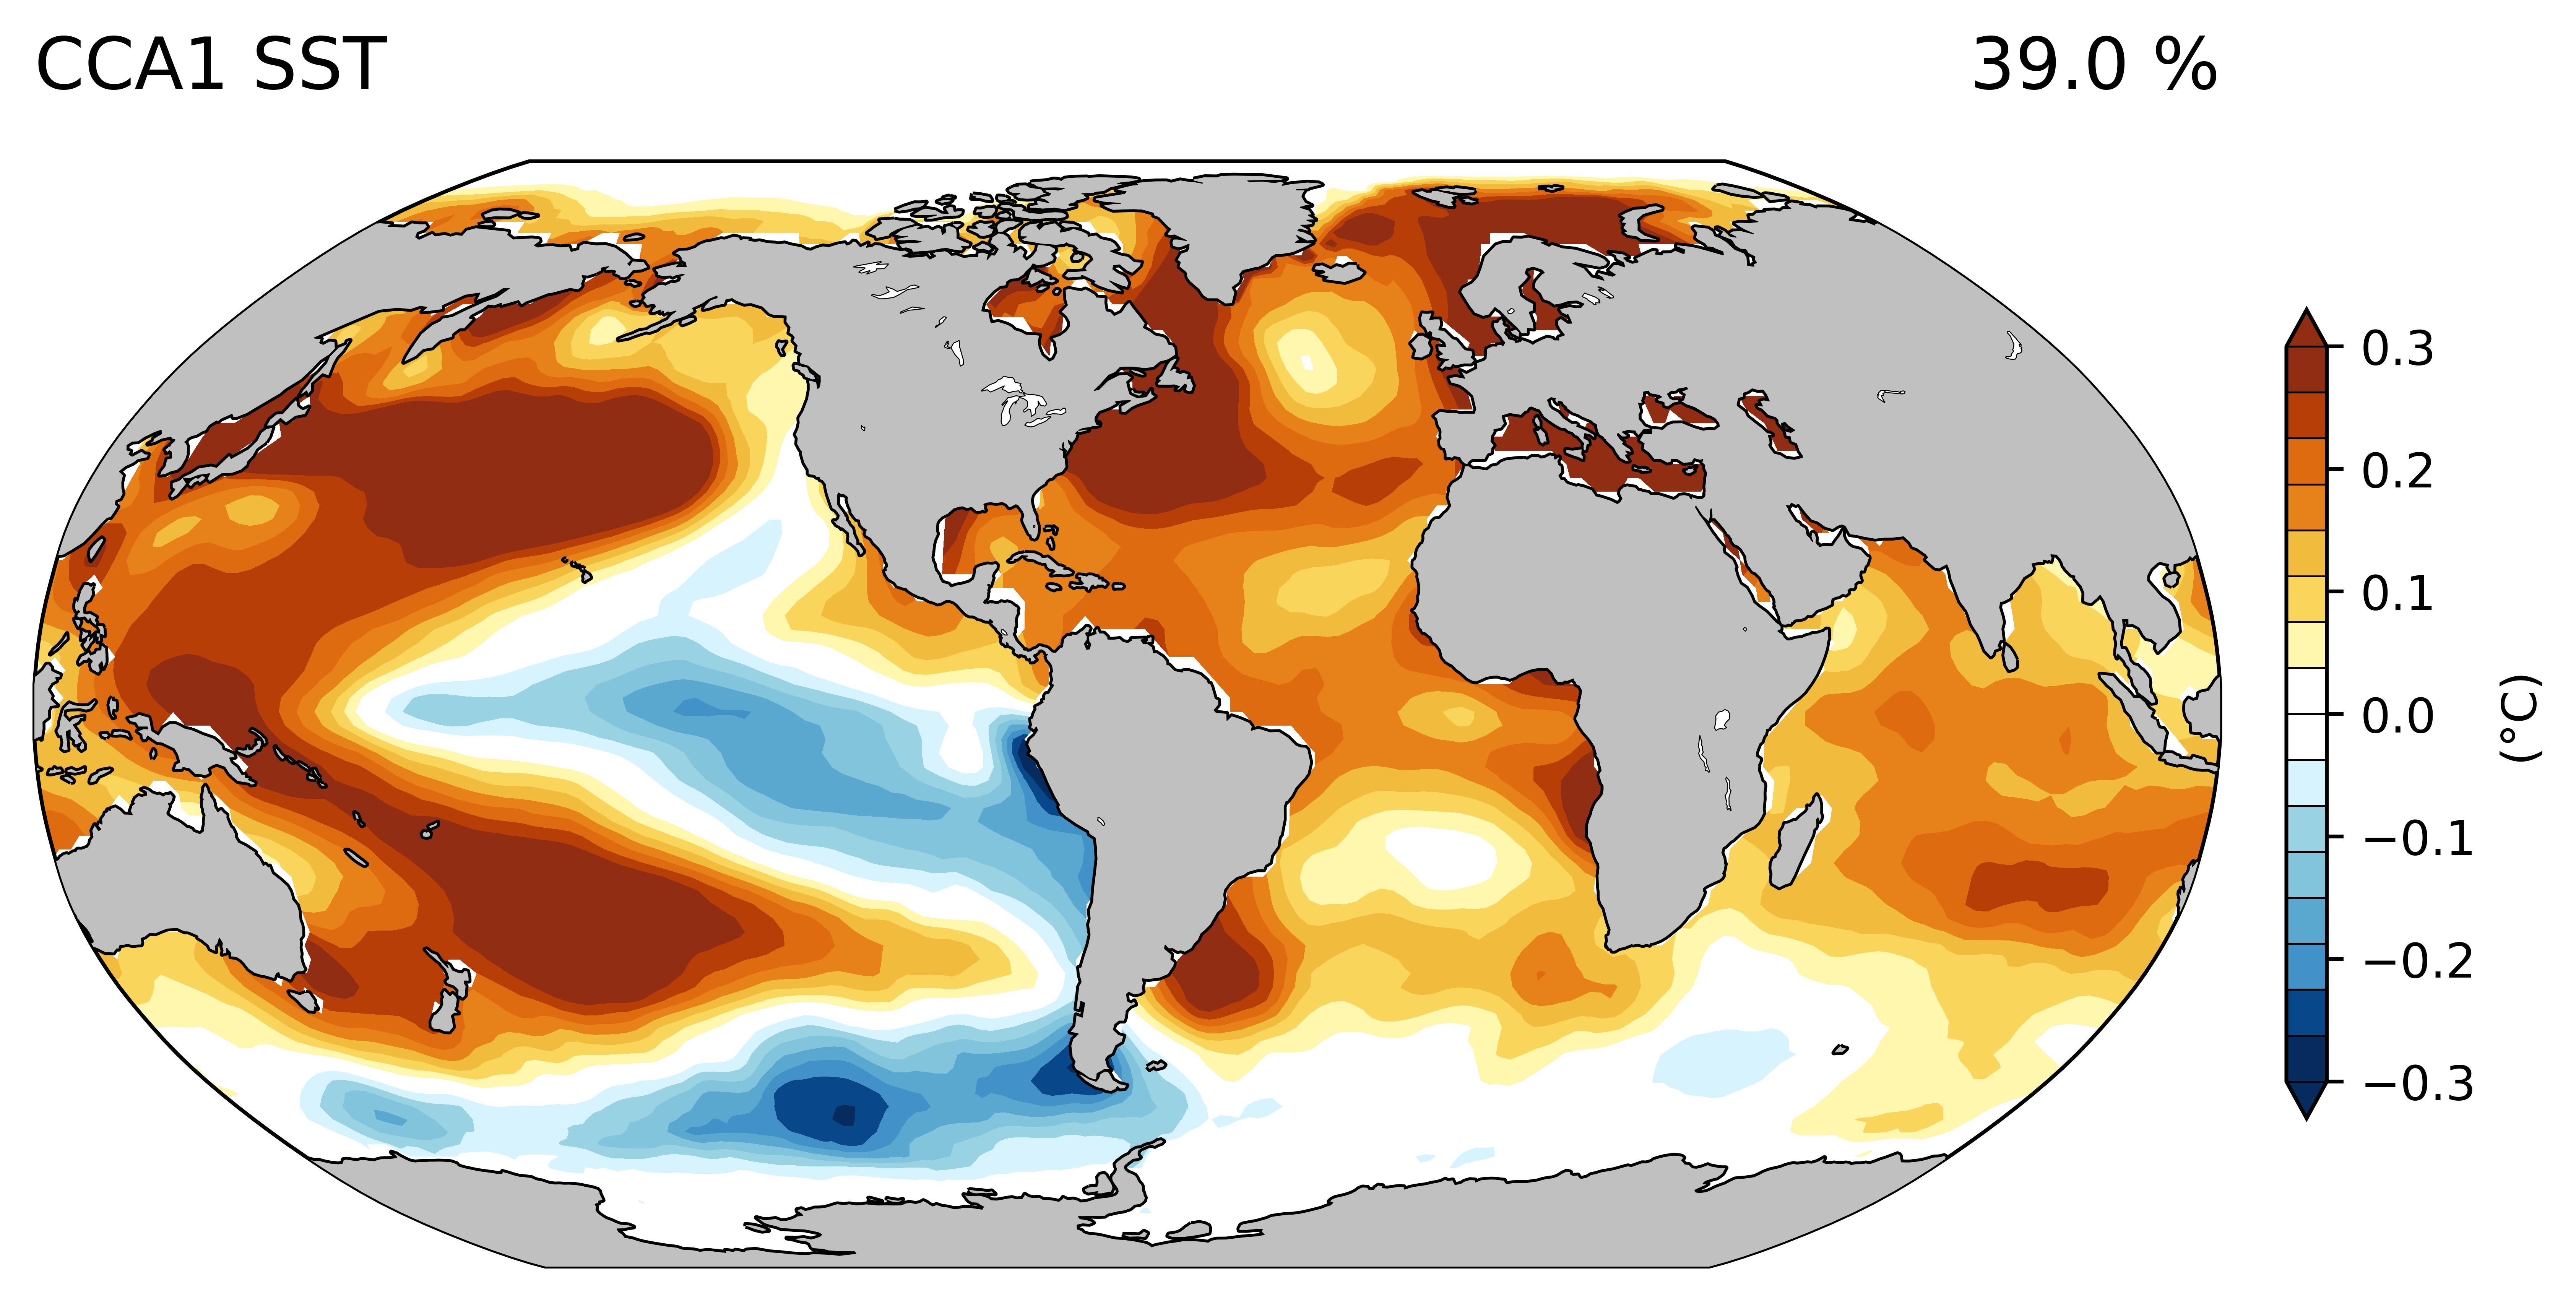

In [20]:
#SST

fig, ax = plt.subplots(figsize=(8, 5), dpi=900, subplot_kw={"projection": ccrs.Robinson(central_longitude=-65)})
#ax.set_extent([-180, 180, -80, 80], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='white', zorder=4)

# Add cyclic point to data to remove the white line over the 0 meridian
data, lon = cutil.add_cyclic_point(regSST1, coord=ds1['lon'])

# Color scheme
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

# Plot the data using the specified color scheme
cf = ax.contourf(lon, ds1['lat'], data, transform=ccrs.PlateCarree(),
                 cmap=cmap, levels=np.linspace(-0.3, 0.3, 17),
                 vmin=-0.3, vmax=0.3,
                 extend='both')

cax = plt.colorbar(cf, ticks=np.arange(-0.4 + 0.1, 0.4, 0.1), drawedges=True,
                   orientation='vertical', label=r"(°C)", pad=0.025,
                   shrink=0.5, aspect=20)

gvutil.set_titles_and_labels(ax,
                             lefttitle='CCA1 SST ',
                             lefttitlefontsize=15,
                             righttitle=f'{var_sst1_round.values} %',
                             righttitlefontsize=15,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)

plt.savefig("Figure_S5a_NSIDC_CCA.SST1.jpg", format="jpg", bbox_inches='tight', dpi=900)
plt.tight_layout()


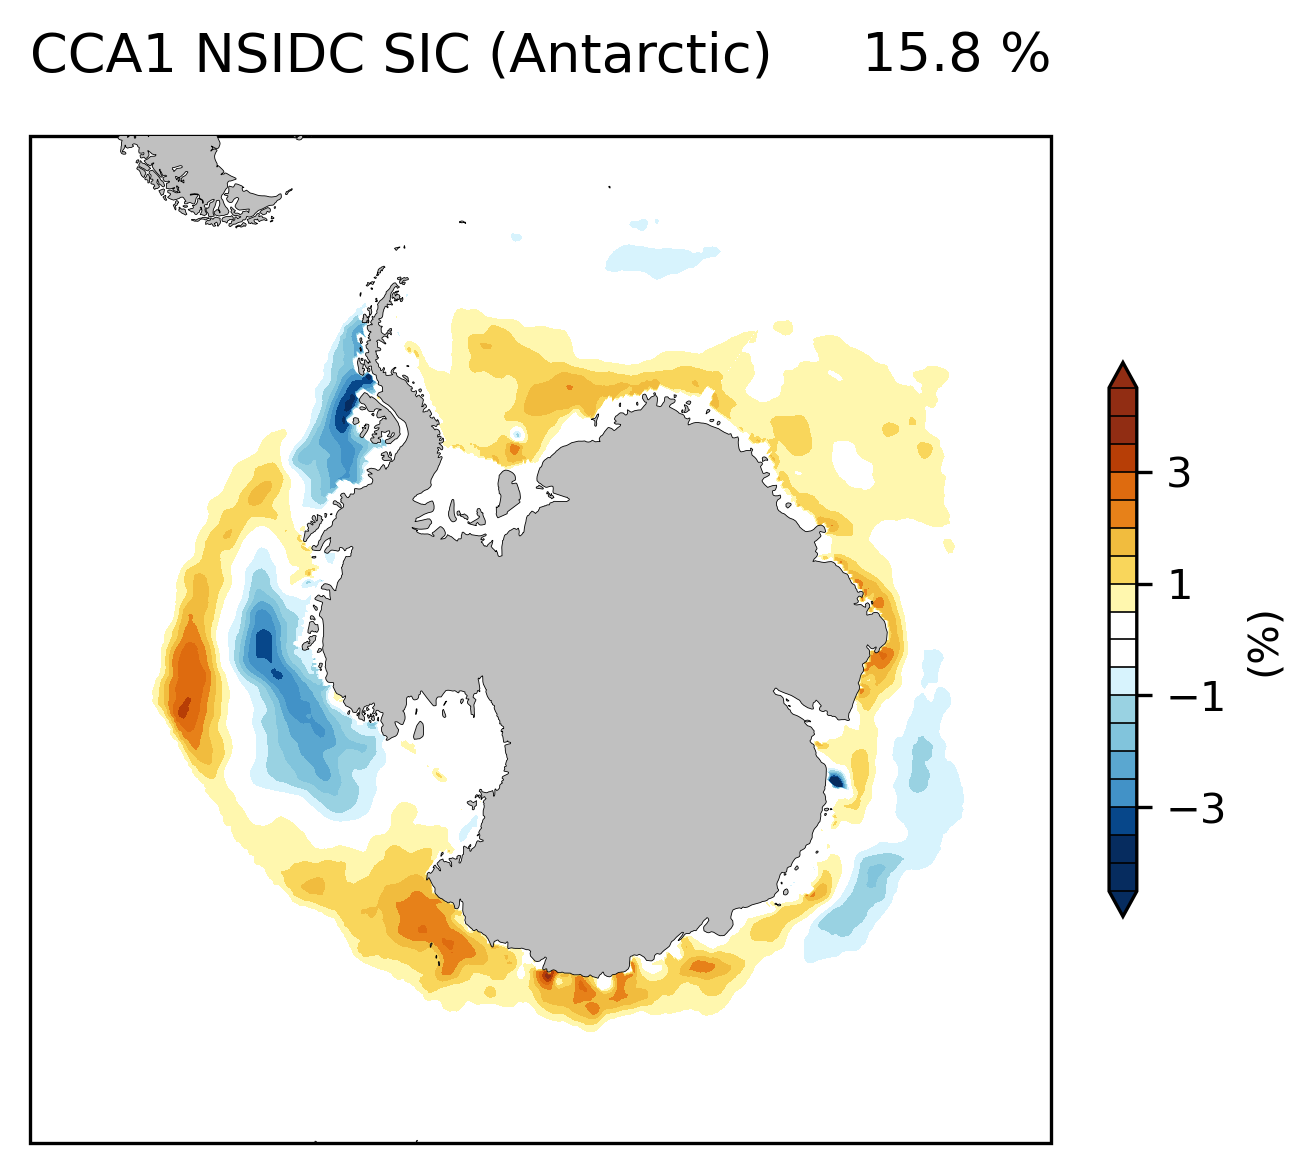

In [21]:
# Antarctic SIC

# Mask Northern Hemisphere SIC
regSIC1_masked = regSIC1.where(regSIC1.lat < -50)

newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1.0, 1.0, 1.0]
color_list[10] = [1.0, 1.0, 1.0]
cmap = mcolors.ListedColormap(color_list)

# Contour levels
level_min = -4
level_max = 4
stepsize = 0.5
levels = np.arange(level_min - stepsize/1, level_max + stepsize/1 + stepsize, stepsize)

# Create plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=300, subplot_kw={"projection": ccrs.SouthPolarStereo(central_longitude=-35)})
ax.set_extent([0, 360, -90, -55], crs=ccrs.PlateCarree())

# Background features
ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='white', zorder=4)

# Titles and labels
gvutil.set_titles_and_labels(ax,
                             lefttitle='CCA1 NSIDC SIC (Antarctic)',
                             lefttitlefontsize=13,
                             righttitle='15.8 %',
                             righttitlefontsize=13,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)

# Plot contourf
cf = ax.contourf(
    regSIC1_masked.lon,
    regSIC1_masked.lat,
    regSIC1_masked * 100,  # scaled to percent
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    vmin=level_min - 0.05,
    vmax=level_max + 0.05,
    extend='both'
)

# Colorbar
cbar = plt.colorbar(
    cf,
    ticks=np.arange(level_min + 1, level_max, 2),
    drawedges=True,
    orientation='vertical',
    label="(%)",
    pad=0.025,
    shrink=0.55,
    aspect=20
)

# Save and show
plt.savefig("Figure_S5f_NSIDC_CCA.SIC1_AA.jpg", format="jpg", bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

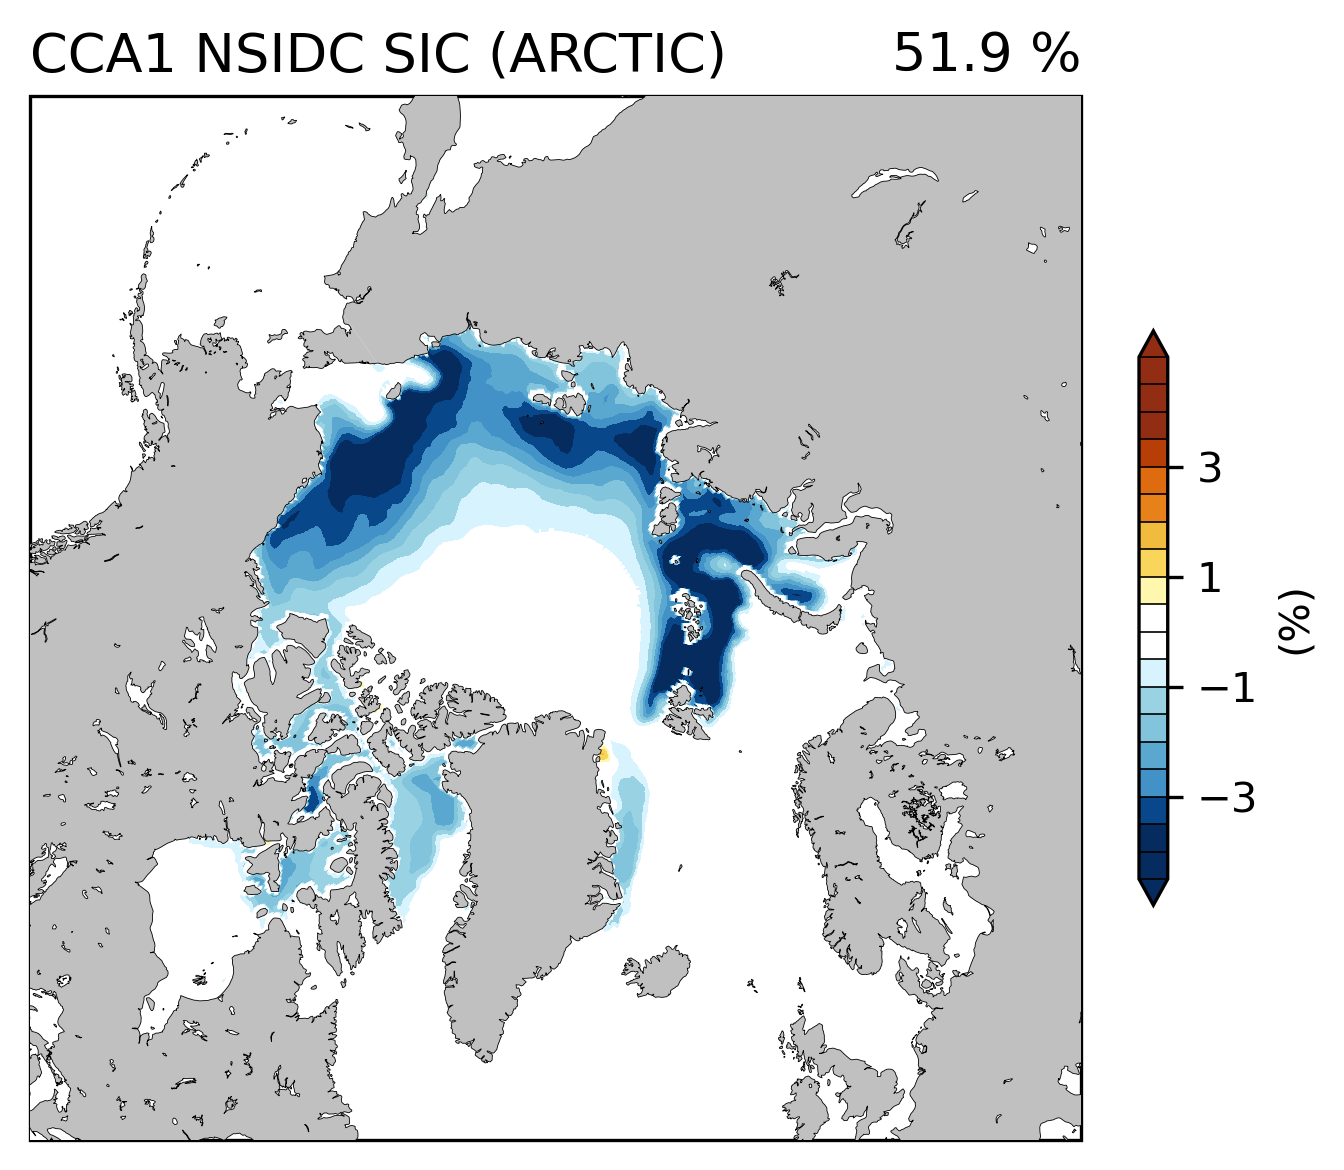

In [22]:
# --- Mask Arctic region ---
regSIC1_masked = regSIC1.where(regSIC1.lat > 50)

# --- Flip latitude and data ---
regSIC1_flipped = regSIC1_masked[::-1, :]         # flip along latitude axis
lat_flipped = regSIC1_masked.lat[::-1]            # flip lat values

# --- Custom colormap ---
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1.0, 1.0, 1.0]
color_list[10] = [1.0, 1.0, 1.0]
cmap = mcolors.ListedColormap(color_list)

# --- Contour levels ---
level_min = -4
level_max = 4
stepsize = 0.5
levels = np.arange(level_min - stepsize, level_max + stepsize + 1, stepsize)

# --- Create figure ---
fig, ax = plt.subplots(figsize=(8, 4), dpi=300,
                       subplot_kw={"projection": ccrs.NorthPolarStereo(central_longitude=-35)})

ax.set_extent([0, 360, 55, 90], crs=ccrs.PlateCarree())

# --- Map features ---
ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2,
               facecolor='white', zorder=4)

# --- Plot the data ---
cf = ax.contourf(
    regSIC1.lon,
    lat_flipped,
    regSIC1_flipped * 100,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    vmin=level_min - 0.05,
    vmax=level_max + 0.05,
    extend='both'
)

# --- Colorbar ---
cbar = plt.colorbar(
    cf,
    ticks=np.arange(level_min + 1, level_max, 2),
    drawedges=True,
    orientation='vertical',
    label="(%)",
    pad=0.025,
    shrink=0.55,
    aspect=20
)

# --- Titles ---
ax.set_title("CCA1 NSIDC SIC (ARCTIC)", fontsize=13, loc='left')
ax.set_title("51.9 %", fontsize=13, loc='right')

# --- Finalize ---
plt.savefig("Figure_S5e_NSIDC_CCA.SIC1_A.jpg", format="jpg", bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

***Combine CO2 with AMO Index (normalized)***

In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load datasets
co2_file = "co2_annmean_mlo.csv"
amo_file = "Annual_Mean_AMO_Index_Short_NOAA_1980_2022.xlsx"

co2_data = pd.read_csv(co2_file)
amo_data = pd.read_excel(amo_file)

# Define correct column names
year_column_co2 = "year"
year_column_amo = "Time"
co2_column = "mean"
amo_column = "Values"

# Filter data from 1980 to 2022
co2_filtered = co2_data[(co2_data[year_column_co2] >= 1980) & (co2_data[year_column_co2] <= 2022)]
amo_filtered = amo_data[(amo_data[year_column_amo] >= 1980) & (amo_data[year_column_amo] <= 2022)]

# Merge datasets on Year (ensure same column name before merging)
merged_data = pd.merge(
    co2_filtered[[year_column_co2, co2_column]].rename(columns={year_column_co2: "Year"}),
    amo_filtered[[year_column_amo, amo_column]].rename(columns={year_column_amo: "Year"}),
    on="Year",
    how="inner"
)

# Normalize both indices using Min-Max Scaling
scaler = MinMaxScaler()
merged_data[[co2_column, amo_column]] = scaler.fit_transform(merged_data[[co2_column, amo_column]])

# Create the new "Value" column by summing the normalized indices
merged_data["Value"] = merged_data[co2_column] + merged_data[amo_column]

# Select only the necessary columns
final_data = merged_data[["Year", "Value"]]

# Save to Excel file
output_file = "AMO_CO2_1980_2022.xlsx"
final_data.to_excel(output_file, index=False)

print(f"Processing complete. The file has been saved as {output_file}.")

Processing complete. The file has been saved as AMO_CO2_1980_2022.xlsx.


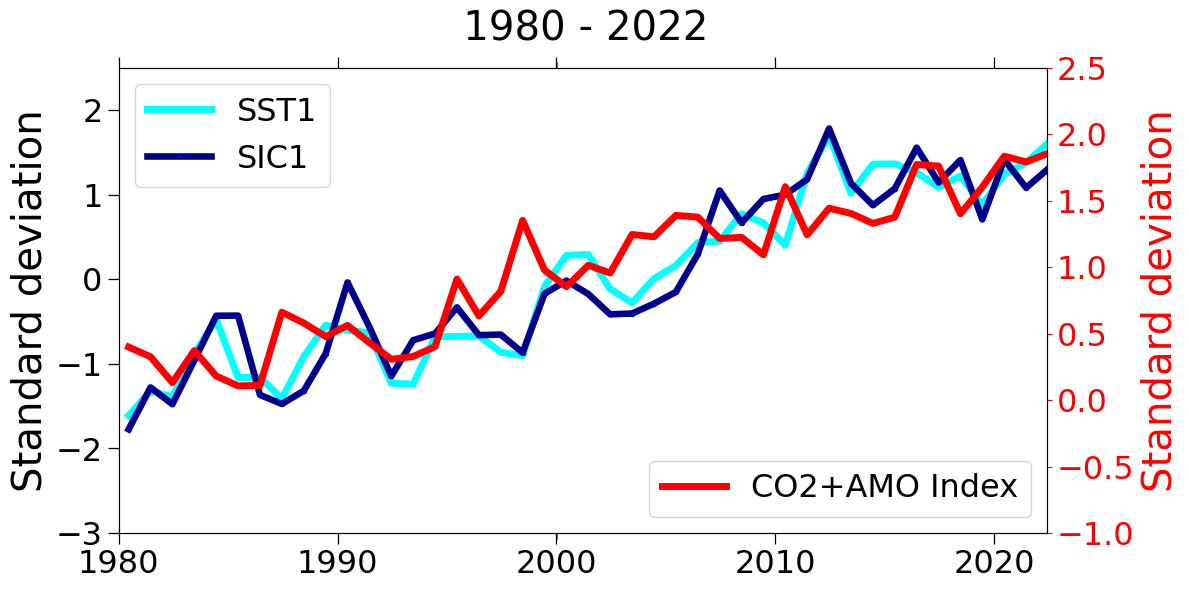

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Correct way to load data from an Excel file
AMO_co2_data = pd.read_excel("AMO_CO2_1980_2022.xlsx")


# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use geocat.viz.util convenience function to set axes tick values
gvutil.set_titles_and_labels(ax1,
                             lefttitle=f'                           1980 - 2022',
                             lefttitlefontsize=29,
                             righttitle=f'',
                             righttitlefontsize=29,
                             xlabel="",
                             ylabel="Standard deviation",
                             labelfontsize=29)
gv.add_major_minor_ticks(ax1,
                         x_minor_per_major=1,
                         y_minor_per_major=1,
                         labelsize=23)

# Plot SST and SIC data
ax1.plot(ds1.time, PC1sst, color='aqua', linewidth=5, label='SST1')
ax1.plot(ds1.time, PC1sic, marker='o', markerfacecolor='blue', markersize=2.8, color='darkblue', linewidth=4.75, label='SIC1')
ax1.legend(prop={"size": 23})

# Set x-axis limits and tick positions
ax1.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2022-06-01'))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=10))
ax1.set_ylim(-3, 2.5)  # Adjust the limits as needed
# Create secondary y-axis for CO2 data
ax2 = ax1.twinx()
ax2.plot(ds1.time, AMO_co2_data['Value'], color='red', linewidth=5, label='CO2+AMO Index')
ax2.set_ylabel('Standard deviation', fontsize=29, color='red')
ax2.tick_params(axis='y', colors='red', labelsize=23)  # Set label font size
ax2.set_ylim(-1, 2.5)  # Adjust the limits as needed
ax2.legend(prop={"size": 23}, loc='lower right')

# Adjust layout and display the plot
plt.savefig("Figure_S5c_NSIDC_CCA1_time_series.jpg", format="jpg", bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

In [25]:
from scipy.stats import pearsonr

In [26]:
# Load the combined AMO_CO2 Index
Index_df = pd.read_excel("AMO_CO2_1980_2022.xlsx")
Index_values = Index_df.iloc[:, 1] 
Index_years = Index_df.iloc[:, 0]  

# Make sure both series are the same length and drop NaNs
df = pd.DataFrame({
    'Index': Index_values,
    'PC1sst': PC1sst
}).dropna()

# Compute Pearson correlation
correlation, p_value = pearsonr(df['PC1sst'], df['Index'])

# Determine significance level
if p_value < 0.01:
    significance_interval = '99% confidence'
elif p_value < 0.05:
    significance_interval = '95% confidence'
else:
    significance_interval = 'No significant correlation'

# Create DataFrame for results
correlation_df = pd.DataFrame({
    'Correlation': [correlation],
    'P-value': [p_value],
    'Significance Interval': [significance_interval]
})

# Output results
print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")
print(f"Significance Interval: {significance_interval}")

Correlation: 0.8636156363485132
P-value: 9.081953379028579e-14
Significance Interval: 99% confidence


***Pair 2***

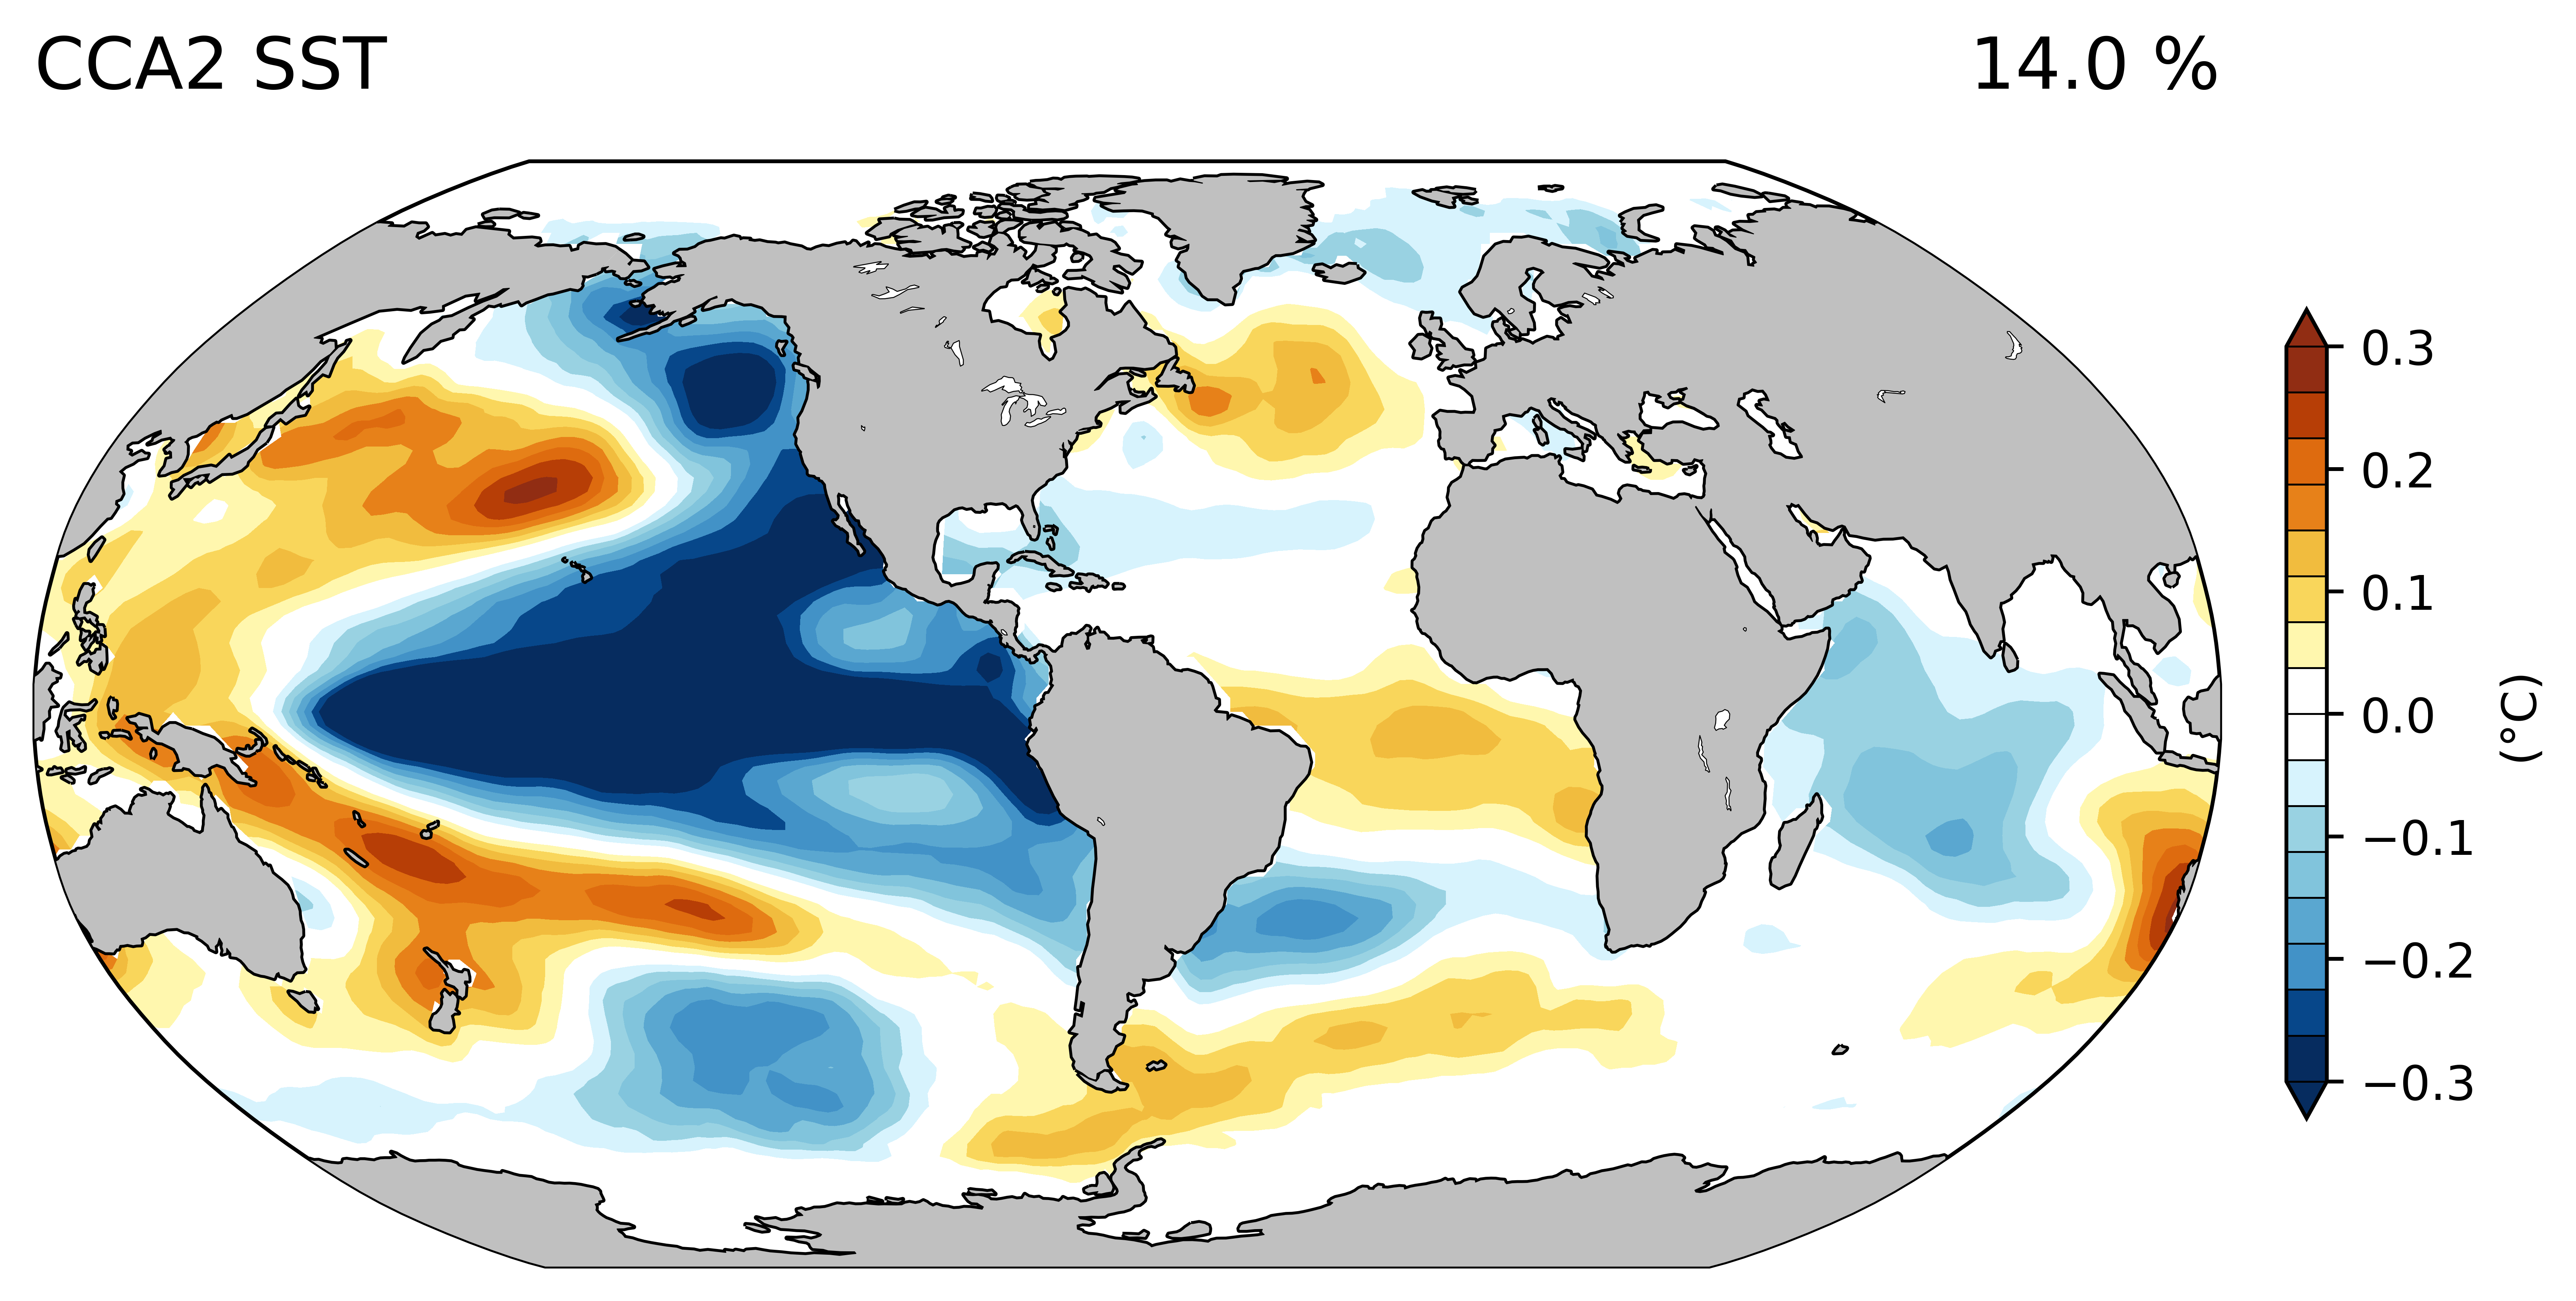

In [27]:
#SST

fig, ax = plt.subplots(figsize=(8, 5), dpi=900, subplot_kw={"projection": ccrs.Robinson(central_longitude=-65)})
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='white', zorder=4)

# Add cyclic point to data to remove the white line over the 0 meridian
data, lon = cutil.add_cyclic_point(regSST2, coord=ds1['lon'])

# Color scheme
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

# Plot the data using the specified color scheme
cf = ax.contourf(lon, ds1['lat'], -data, transform=ccrs.PlateCarree(),
                 cmap=cmap, levels=np.linspace(-0.3, 0.3, 17),
                 vmin=-0.3, vmax=0.3,
                 extend='both')

cax = plt.colorbar(cf, ticks=np.arange(-0.4 + 0.1, 0.4, 0.1), drawedges=True,
                   orientation='vertical', label=r"(°C)", pad=0.025,
                   shrink=0.5, aspect=20)

gvutil.set_titles_and_labels(ax,
                             lefttitle='CCA2 SST ',
                             lefttitlefontsize=15,
                             righttitle=f'{var_sst2_round.values} %',
                             righttitlefontsize=15,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)
plt.savefig("Figure_S5b_NSIDC_CCA.SST2.jpg", format="jpg", bbox_inches='tight', dpi=900)
plt.tight_layout()


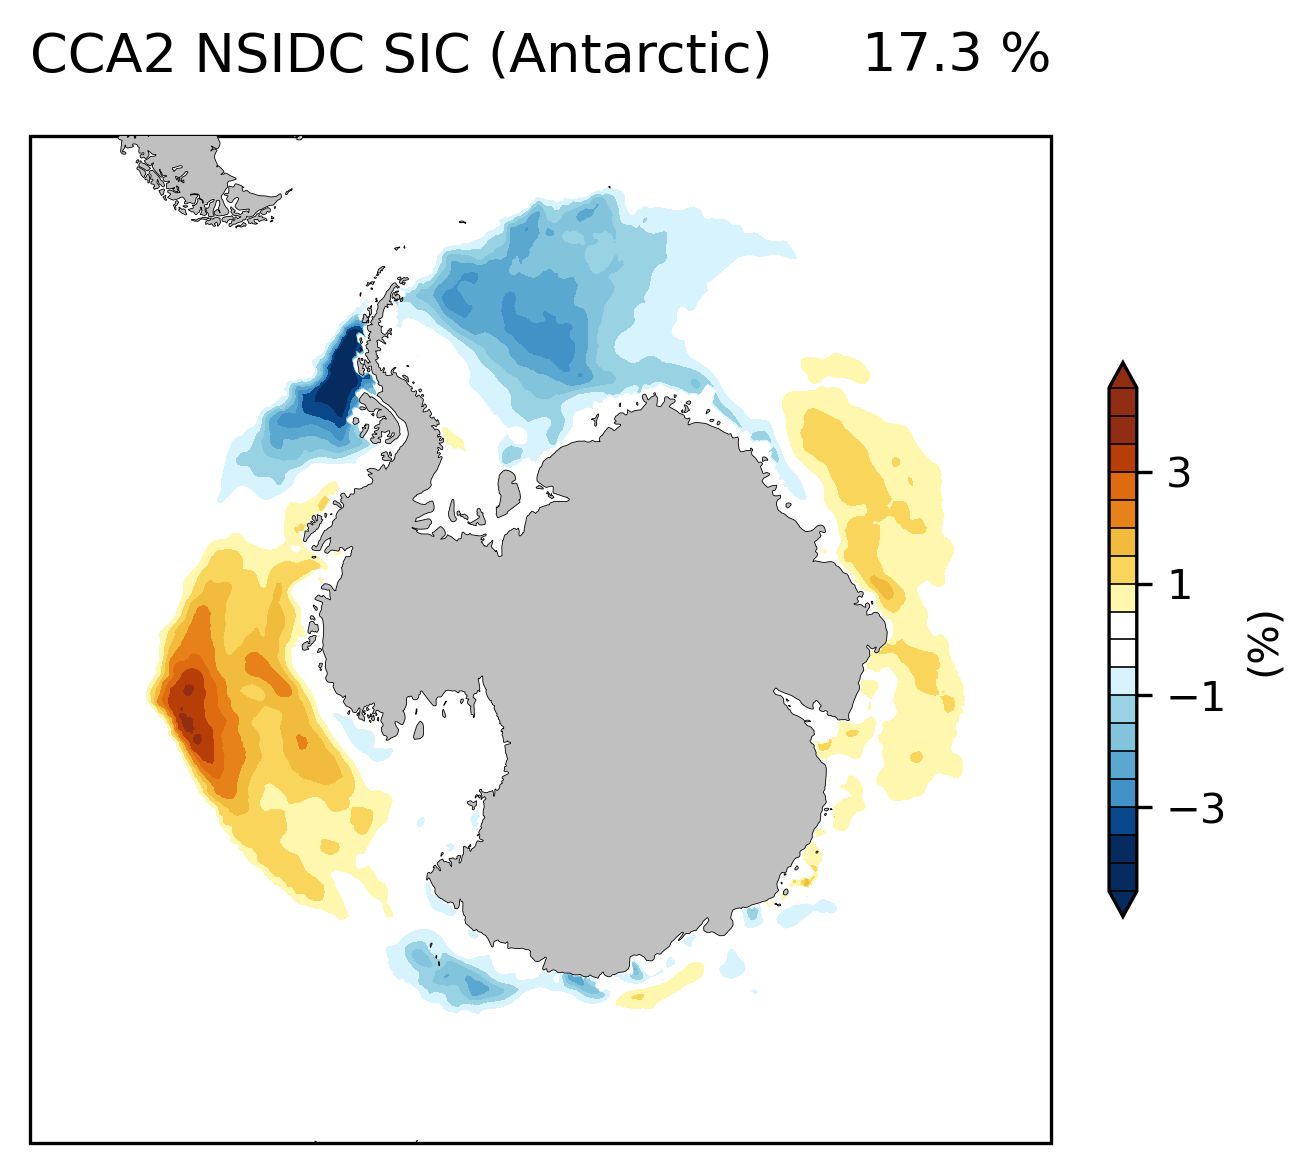

In [28]:
# Antarctic SIC

# Mask Northern Hemisphere SIC
regSIC2_masked = regSIC2.where(regSIC2.lat < -50)

# Custom colormap from BlueYellowRed with white at center
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1.0, 1.0, 1.0]
color_list[10] = [1.0, 1.0, 1.0]
cmap = mcolors.ListedColormap(color_list)

# Contour levels
level_min = -4
level_max = 4
stepsize = 0.5
levels = np.arange(level_min - stepsize/1, level_max + stepsize/1 + stepsize, stepsize)

# Create plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=300, subplot_kw={"projection": ccrs.SouthPolarStereo(central_longitude=-35)})
ax.set_extent([0, 360, -90, -55], crs=ccrs.PlateCarree())

# Background features
ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='white', zorder=4)

# Titles and labels
gvutil.set_titles_and_labels(ax,
                             lefttitle='CCA2 NSIDC SIC (Antarctic)',
                             lefttitlefontsize=13,
                             righttitle='17.3 %',
                             righttitlefontsize=13,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)

# Plot 
cf = ax.contourf(
    regSIC2_masked.lon,
    regSIC2_masked.lat,
    -regSIC2_masked * 100,  # scaled to percent
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    vmin=level_min - 0.05,
    vmax=level_max + 0.05,
    extend='both'
)

# Colorbar
cbar = plt.colorbar(
    cf,
    ticks=np.arange(level_min + 1, level_max, 2),
    drawedges=True,
    orientation='vertical',
    label="(%)",
    pad=0.025,
    shrink=0.55,
    aspect=20
)

# Save and show
plt.savefig("Figure_S5h_NSIDC_CCA.SIC2_AA.jpg", format="jpg", bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

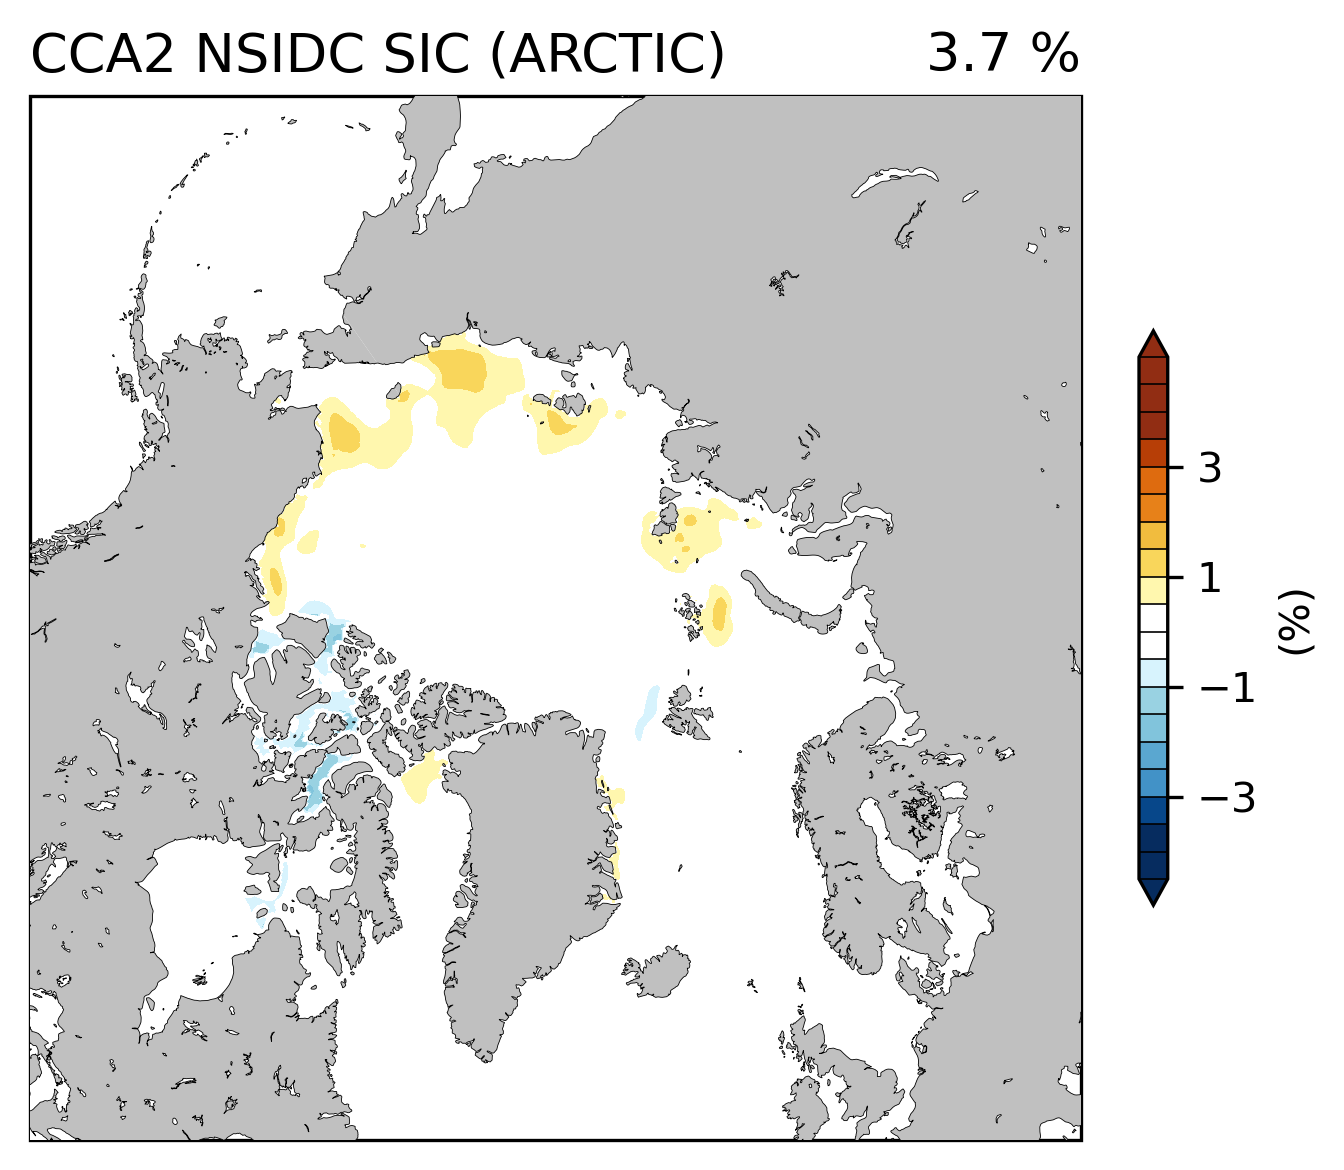

In [29]:
# --- Mask Arctic region ---
regSIC2_masked = regSIC2.where(regSIC2.lat > 50)

# --- Flip latitude and data ---
regSIC2_flipped = regSIC2_masked[::-1, :]         # flip along latitude axis
lat_flipped = regSIC2_masked.lat[::-1]            # flip lat values

# --- Custom colormap ---
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1.0, 1.0, 1.0]
color_list[10] = [1.0, 1.0, 1.0]
cmap = mcolors.ListedColormap(color_list)

# --- Contour levels ---
level_min = -4
level_max = 4
stepsize = 0.5
levels = np.arange(level_min - stepsize, level_max + stepsize + 1, stepsize)

# --- Create figure ---
fig, ax = plt.subplots(figsize=(8, 4), dpi=300,
                       subplot_kw={"projection": ccrs.NorthPolarStereo(central_longitude=-35)})

ax.set_extent([0, 360, 55, 90], crs=ccrs.PlateCarree())

# --- Map features ---
ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2,
               facecolor='white', zorder=4)

# --- Plot
cf = ax.contourf(
    regSIC2.lon,
    lat_flipped,
    -regSIC2_flipped * 100,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    vmin=level_min - 0.05,
    vmax=level_max + 0.05,
    extend='both'
)

# --- Colorbar ---
cbar = plt.colorbar(
    cf,
    ticks=np.arange(level_min + 1, level_max, 2),
    drawedges=True,
    orientation='vertical',
    label="(%)",
    pad=0.025,
    shrink=0.55,
    aspect=20
)

# --- Titles ---
ax.set_title("CCA2 NSIDC SIC (ARCTIC)", fontsize=13, loc='left')
ax.set_title("3.7 %", fontsize=13, loc='right')

# --- Finalize ---
plt.savefig("Figure_S5g_NSIDC_CCA.SIC2_A.jpg", format="jpg", bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

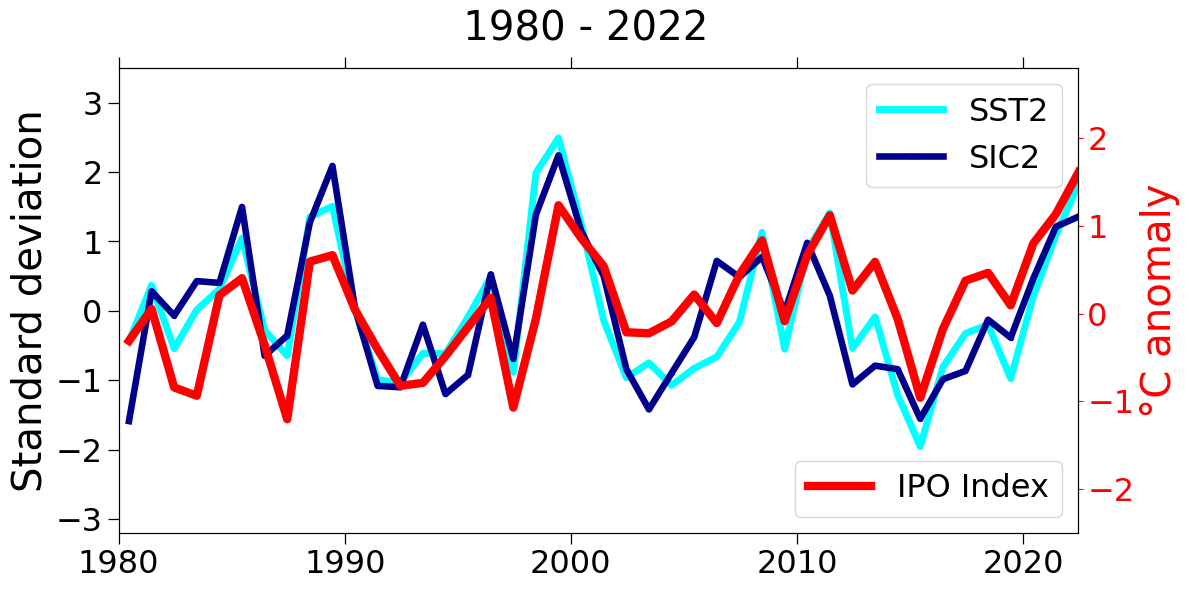

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Correct way to load data from an Excel file
IPO_data = pd.read_excel("IPO_Index_Unfilred_Tripole_1980_2022.xlsx")


# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(12, 6))

gvutil.set_titles_and_labels(ax1,
                             lefttitle=f'                           1980 - 2022',
                             lefttitlefontsize=29,
                             righttitle=f'',
                             righttitlefontsize=29,
                             xlabel="",
                             ylabel="Standard deviation",
                             labelfontsize=29)
gv.add_major_minor_ticks(ax1,
                         x_minor_per_major=1,
                         y_minor_per_major=1,
                         labelsize=23)

# Plot SST and SIC data
ax1.plot(ds1.time, -PC2sst, color='aqua', linewidth=5, label='SST2')
ax1.plot(ds1.time, -PC2sic, marker='o', markerfacecolor='blue', markersize=2.8, color='darkblue', linewidth=4.75, label='SIC2')
ax1.legend(prop={"size": 23})

# Set x-axis limits and tick positions
ax1.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2022-06-01'))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=10))
ax1.set_ylim(-3.2, 3.5)  
ax1.legend(prop={"size": 23}, loc='upper right')
ax2 = ax1.twinx()
ax2.plot(ds1.time, -IPO_data['Values'], color='red', linewidth=6, label='IPO Index')
ax2.set_ylabel('°C anomaly', fontsize=29, color='red')
ax2.tick_params(axis='y', colors='red', labelsize=23)  # Set label font size
ax2.set_ylim(-2.5, 2.8)  
ax2.legend(prop={"size": 23}, loc='lower right')

# Adjust layout and display the plot
plt.savefig("Figure_S5d_NSIDC_CCA2_time_series.jpg", format="jpg", bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

In [31]:
from scipy.stats import pearsonr

In [32]:
# Load the combined AMO_CO2 Index
Index_df = pd.read_excel("IPO_Index_Unfilred_Tripole_1980_2022.xlsx")
Index_values = Index_df.iloc[:, 1] 
Index_years = Index_df.iloc[:, 0]  

# Make sure both series are the same length and drop NaNs
df = pd.DataFrame({
    'Index': Index_values,
    'PC2sst': PC2sst
}).dropna()

# Compute Pearson correlation
correlation, p_value = pearsonr(df['PC2sst'], df['Index'])

# Determine significance level
if p_value < 0.01:
    significance_interval = '99% confidence'
elif p_value < 0.05:
    significance_interval = '95% confidence'
else:
    significance_interval = 'No significant correlation'

# Create DataFrame for results
correlation_df = pd.DataFrame({
    'Correlation': [correlation],
    'P-value': [p_value],
    'Significance Interval': [significance_interval]
})

# Output results
print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")
print(f"Significance Interval: {significance_interval}")

Correlation: 0.7270129346409284
P-value: 3.3746376554265555e-08
Significance Interval: 99% confidence
